In [229]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
%matplotlib inline

# Метод ближайшего соседа (NN)

In [2]:
def NN(x, data, y, distance):
    distances = np.fromiter(map(lambda i: distance(x-i), data), float)
    return y[distances.argmin()]

In [3]:
def evclid_distance(x):
    r = 0
    for i in range(len(x)):
        r+=x[i]**2
    return r**0.5

In [194]:
def generate_data(all_count, classes, classters, dimentions, scatter):
    res = []
    y = []
    c_in_class = all_count//classters
    for k in range(classters):
        c = random.randint(1,classes)
        d = [0]*dimentions
        for i in range(dimentions):
            d[i] = random.random()
        for i in range(c_in_class):
            r = [0]*dimentions
            for j in range(dimentions):
                r[j] = d[j]+random.random()/5*scatter-0.1*scatter
                if r[j] < 0:
                    r[j] = 0
                if r[j] > 1:
                    r[j] = 1
            res.append(r)
            y.append(c)
    res = np.array(res)
    y = np.array(y)
    return res, y

In [253]:
data, y = generate_data(100, 2, 20, 2, 1)


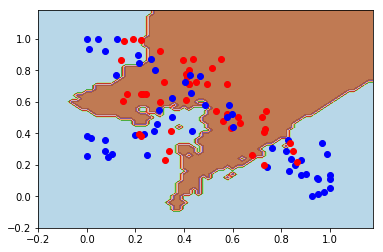

In [256]:
h = 0.02
xx, yy = np.meshgrid(np.arange(-0.2, 1.2, h), np.arange(-0.2, 1.2, h))
Z = np.fromiter(map(lambda i: parzen_variable(i, 12, data, y, evclid_distance, Rect_kernel),
                    np.c_[xx.ravel(), yy.ravel()]), float).reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

for i in range(len(y)):
    plt.scatter(data[i, 0], data[i, 1], color = "blue" if y[i]==1 else "red")

In [50]:
NN(x, data, y, evclid_distance)

2

# Метод k-ближайших соседей k-NN

In [28]:
def k_NN(x, k, data, y, distance):
    distances = sorted(enumerate(map(lambda i: distance(x-i), data)),
                       key = lambda i: i[1])[:k]
    d={}
    for index, i in distances:
        if y[index] not in d:
            d[y[index]] = 0
        d[y[index]]+=1
    a = max(d.items(), key = lambda i: i[1])
    return a[0]

## Оптимизация числа соседей
Функционал скользящего контроля leav-one-out
$$ LOO(k,X^l) = \sum_{i=1}^l[a(x_i:X^l/{x_i}, k) \neq y_i] \rightarrow min_k$$

In [241]:
def LOO(data, y, distance, func):
    n = data.shape[0]
    sum_k = {}
    for i in range(n):
        n_data = np.vstack([data[:i], data[i+1:]])
        n_y = np.concatenate([y[:i], y[i+1:]])
        for j in range(1, n-2):
            res = func(data[i], j, n_data, n_y, distance)
            if j not in sum_k:
                sum_k[j] = 0
            if res != y[i]:
                sum_k[j]+=1
    prev = None
    for i in sum_k.items():
        if prev is not None:
            plt.plot([prev[0],i[0]], [prev[1], i[1]], color = "red")
        prev = i
    return min(sum_k.items(), key = lambda item:item[1])[0]

12

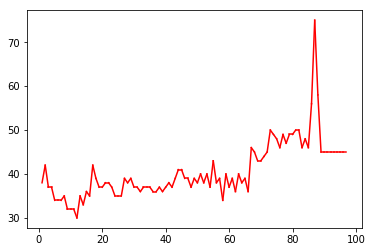

In [255]:
LOO(data, y, evclid_distance, lambda a1, a2, a3, a4, a5: 
    parzen_variable(a1, a2,a3,a4,a5,Rect_kernel))

# Метод k-взвешенных ближайших соседей
## Возможные эвристики
- $w_i=(k+1-i)/k$ - линейно убыва.щие веса;
- $w_i = q^i$ - экспоненциально убывающие веса, $0<q<1$;

In [114]:
def k_NN_w(x, k, data, y, distance, weight):
    distances = sorted(enumerate(map(lambda i: distance(x-i), data)), key = lambda i: i[1])[:k]
    d={}
    for index, i in enumerate(map(lambda x:x[0], distances)):
        if y[i] not in d:
            d[y[i]] = 0
        d[y[i]]+=1*weight(index)
    a = max(d.items(), key = lambda i: i[1])
    return a[0]

In [115]:
def eksponent_weight(q, i):
    return q**i

In [126]:
def line_weight(k,i):
    return (k+1-i)/k

# Метод окна Парзена
## Метод парзеновского окна фиксированной ширины:
$$ a(u; X^l, h, K)=arg max_{y\in Y} \sum_{i=1}^l [y^{(i)}_u = y] K(p(u,x_u^{(i)})/h)$$
## Метод парзеновского окна переменной ширины:
$$ a(u; X^l, k, K)=arg max_{y\in Y} \sum_{i=1}^l [y^{(i)}_u = y] K(p(u,x_u^{(i)})/p(u, x^{(k+1)}_u))$$

In [257]:
def parzen_variable(x, k, data, y, distance, kernel, weight = None):
    if weight is None:
        weight = [1]*data.shape[0]
    distances = sorted(enumerate(map(lambda i: distance(x-i), data)), key = lambda i: i[1])
    d={}
    for index, i in enumerate(map(lambda x:x[0], distances)):
        if y[i] not in d:
            d[y[i]] = 0
        d[y[i]]+=weight[i]*kernel(distances[index][1]/distances[k+1][1])
    a = max(d.items(), key = lambda i: i[1])
    return a[0]

In [258]:
def parzen_fixed(x, h, data, y, distance, kernel, weight = None):
    if weight is None:
        weight = [1]*data.shape[0]
    distances = sorted(enumerate(map(lambda i: distance(x-i), data)), key = lambda i: i[1])
    d={}
    for index, i in enumerate(map(lambda x:x[0], distances)):
        if y[i] not in d:
            d[y[i]] = 0
        d[y[i]]+=weight[i]*kernel(distances[index][1]/h)
    a = max(d.items(), key = lambda i: i[1])
    return a[0]

### Ядро Епаничникова
$$ E(r)=3/4(1-r^2)[|r|<=1]$$
### Квартическое ядро
$$ Q(r)=15/16(1-r^2)^2[|r|<=1]$$
### Треугольное ядро
$$ T(r)=(1-|r|)[|r|<=1]$$
### Гаусовское ядро
$$ G(r)=(2\pi)^{(-1/2)}e^{(-1/2r^2)}$$
### Прямоугольное ядро
$$ P(r) = 1/2[|r|<=1]$$

In [230]:
def Epanich_kernel(r):
    return (3/4)*(1-r**2)*(1 if math.fabs(r)<= 1 else 0)

In [231]:
def Squered_kernel(r):
    return (15/16)*(1-r**2)**2*(1 if math.fabs(r)<= 1 else 0)

In [232]:
def Triangle_kernel(r):
    return (1-math.fabs(r))*(1 if math.fabs(r)<= 1 else 0)

In [236]:
def Gaus_kernel(r):
    return (2*math.pi)**(-1/2)*math.e**(-(1/2)*r**2)

In [234]:
def Rect_kernel(r):
    return (1/2)*(1 if math.fabs(r)<= 1 else 0)

# Метод потенциальных функций
$$ a(u; X^l, h, K)=arg max_{y\in Y} \sum_{i=1}^l [y^{(i)}_u = y] \gamma_i K(p(u,x_u^{(i)})/h)$$

## Взвешенная метрика Минковского:
$$ p(u, x) = (\sum_{j=1}^nw_j|f_j(u)-f_j(x_i)|^p)^{1/p}$$

В частности, если $w_j=1$ и $p=2$, то имеем евклидову метрику

In [259]:
def minkov_distance(x, w, p):
    r = 0
    for i in range(len(x)):
        r+=w[i]*x[i]**p
    return r**(1/p)

# SKLEARN 

In [48]:
!pip install -U scikit-learn --user

Requirement already up-to-date: scikit-learn in c:\users\misha\anaconda3\lib\site-packages (0.20.2)


In [52]:
from  sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
import pandas as pd
import quandl
import math
import numpy as np

In [26]:
df = quandl.get('WIKI/GOOGL')

df = df[["Adj. Open", "Adj. High", "Adj. Low", "Adj. Close", "Adj. Volume"]]
df['HL_PCT'] = (df["Adj. High"]- df["Adj. Close"])/df["Adj. Close"]*100.0
df['PCT_change'] = (df["Adj. Close"]- df["Adj. Open"])/df["Adj. Open"]*100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

forecast_col = 'Adj. Close'
df.fillna(-999999, inplace = True)

forecast_out = int(math.ceil(0.01*len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)
df.dropna(inplace=True)

In [54]:
X = np.array(df.drop(['label'], 1))
y = np.array(df['label'])
X = preprocessing.scale(X)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection .train_test_split(X, y, test_size = 0.2)